In [3]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer, KNNImputer
import matplotlib.dates as mdates

In [4]:
# Read the data
df_check = pd.read_excel('check_data_to_students.xlsx')
df_train = pd.read_excel("train_data.xlsx")
df_validation = pd.read_excel("validation_data.xlsx")

# Prepare Train Data for Preprocessing
df_train['Date'] = pd.to_datetime(df_train['Date'])
df_train.set_index('Date', inplace=True)

power_columns = [f"Power{i}" for i in range(1, 97)]    # Define the list of power columns (assumes columns are named "Power1", "Power2", ..., "Power96")

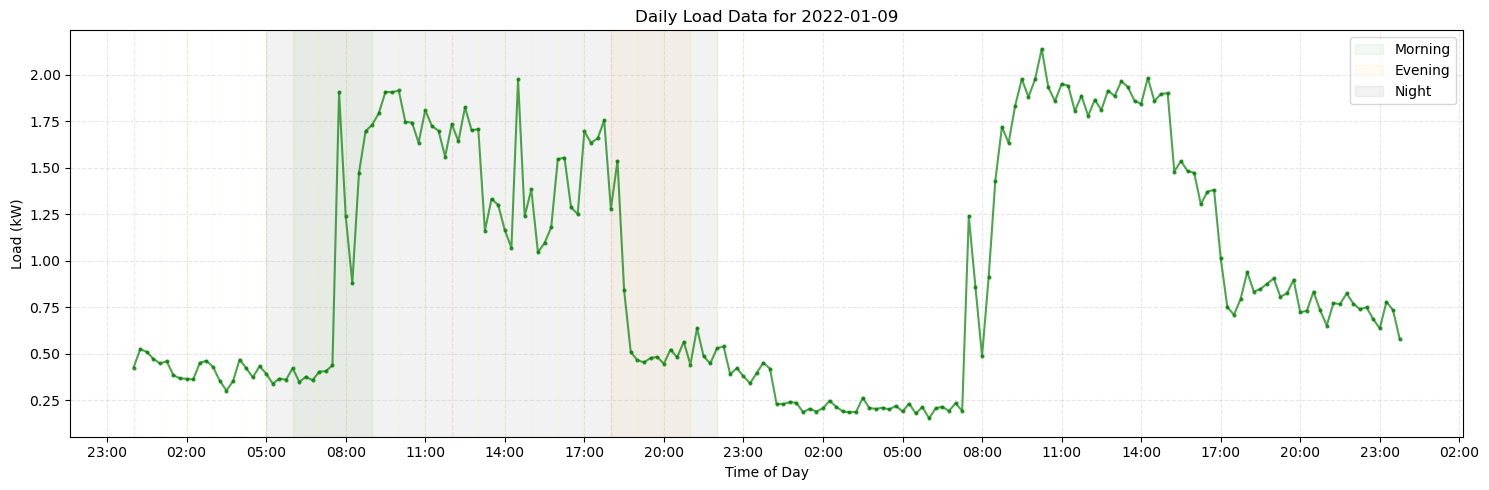

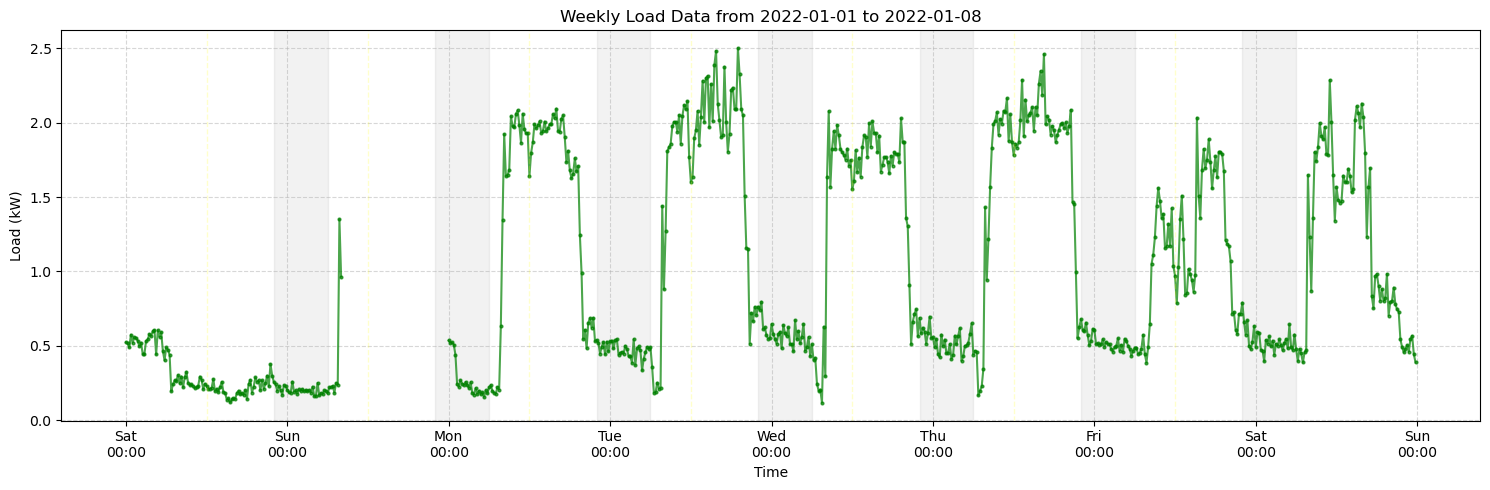

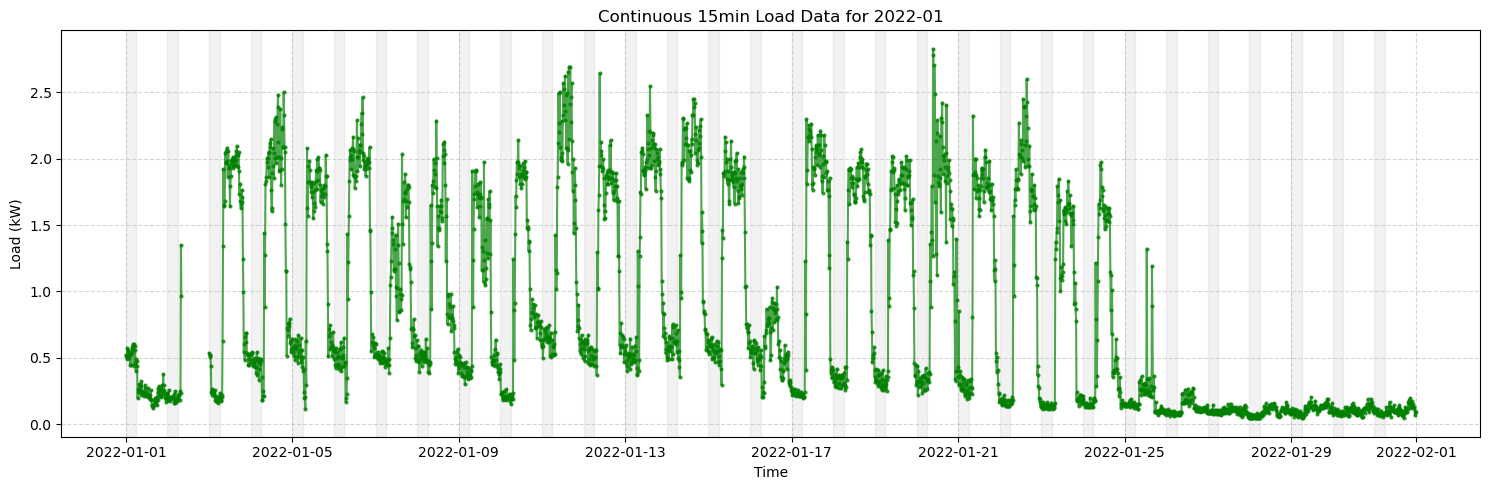

In [5]:
# Function to Plot Data Over Daily Period
def plot_daily_load_data(df, day_date, power_columns, freq='15min', 
                        marker_size=2, color='blue', figsize=(15, 5)):
    # Input validation
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame must have a DatetimeIndex")
    
    try:
        day_date = pd.to_datetime(day_date)
        next_day = day_date + pd.Timedelta(days=1)
    except:
        raise ValueError("day_date must be in 'YYYY-MM-DD' format")
    
    # Filter data for the day
    try:
        df_day = df.loc[day_date:next_day].copy()
        if len(df_day) == 0:
            raise ValueError("No data found for the specified day")
    except Exception as e:
        available_dates = f"{df.index[0].date()} to {df.index[-1].date()}"
        raise ValueError(f"Date not available. Data exists from {available_dates}") from e
    
    # Process data
    flattened_data = df_day[power_columns].values.flatten()
    time_axis = pd.date_range(
        start=df_day.index[0], 
        periods=len(flattened_data), 
        freq=freq
    )
    
    # Plotting
    plt.figure(figsize=figsize)
    plt.plot(
        time_axis, 
        flattened_data, 
        marker='o', 
        linestyle='-', 
        markersize=marker_size, 
        color=color,
        alpha=0.7
    )
    
    # Formatting
    plt.title(f'Daily Load Data for {day_date.date()}')
    plt.xlabel('Time of Day')
    plt.ylabel('Load (kW)')
    plt.grid(True, which='both', linestyle='--', alpha=0.3)
    
    # Add time period shading
    ax = plt.gca()
    
    # Morning (6AM-9AM)
    ax.axvspan(
        day_date.replace(hour=6), 
        day_date.replace(hour=9), 
        color='green', 
        alpha=0.05,
        label='Morning'
    )
    
    # Evening (6PM-9PM)
    ax.axvspan(
        day_date.replace(hour=18), 
        day_date.replace(hour=21), 
        color='orange', 
        alpha=0.05,
        label='Evening'
    )
    
    # Night (10PM-5AM)
    ax.axvspan(
        day_date.replace(hour=22), 
        day_date.replace(hour=5), 
        color='gray', 
        alpha=0.1,
        label='Night'
    )
    
    # Add hour markers
    for hour in range(0, 24):
        ax.axvline(
            day_date.replace(hour=hour),
            color='red' if hour in [0, 12, 18] else 'yellow',
            alpha=0.1,
            linestyle='--',
            linewidth=1
        )
    
    # Format x-axis to show hours
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=3))
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return df_day

# Function to Plot Data Over Weekly Period
def plot_weekly_load_data(df, start_date, power_columns, freq='15min', 
                         marker_size=2, color='blue', figsize=(15, 5)):
    # Input validation
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame must have a DatetimeIndex")
    
    try:
        start_date = pd.to_datetime(start_date)
        end_date = start_date + pd.Timedelta(days=7)
    except:
        raise ValueError("start_date must be in 'YYYY-MM-DD' format")
    
    # Filter data for the week
    try:
        df_week = df.loc[start_date:end_date].copy()
        if len(df_week) == 0:
            raise ValueError("No data found for the specified week")
    except Exception as e:
        available_dates = f"{df.index[0].date()} to {df.index[-1].date()}"
        raise ValueError(f"Date range not available. Data exists from {available_dates}") from e
    
    # Process data
    flattened_data = df_week[power_columns].values.flatten()
    time_axis = pd.date_range(
        start=df_week.index[0], 
        periods=len(flattened_data), 
        freq=freq
    )
    
    # Plotting
    plt.figure(figsize=figsize)
    plt.plot(
        time_axis, 
        flattened_data, 
        marker='o', 
        linestyle='-', 
        markersize=marker_size, 
        color=color,
        alpha=0.7
    )
    
    # Formatting
    plt.title(f'Weekly Load Data from {start_date.date()} to {end_date.date()}')
    plt.xlabel('Time')
    plt.ylabel('Load (kW)')
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    
    # Add shaded nights and day markers
    ax = plt.gca()
    for day in pd.date_range(start_date, periods=7, freq='D'):
        # Night shading (10PM-6AM)
        ax.axvspan(
            day.replace(hour=22), 
            (day + pd.Timedelta(days=1)).replace(hour=6), 
            color='gray', 
            alpha=0.1
        )
        # Noon marker
        ax.axvline(
            day.replace(hour=12),
            color='yellow',
            alpha=0.2,
            linestyle='--',
            linewidth=1
        )
    
    # Format x-axis to show days clearly
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%a\n%H:%M'))
    plt.tight_layout()
    plt.show()
    
    return df_week

# Function to Plot Data Over Monthly Period
def plot_monthly_load_data(df, month_str, power_columns, freq='15min', 
                          marker_size=2, color='blue', figsize=(15, 5)):
    # Input validation
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame must have a DatetimeIndex")
    
    if month_str not in df.index.strftime('%Y-%m').unique():
        available_months = df.index.strftime('%Y-%m').unique()
        raise ValueError(f"Month not found. Available months: {available_months}")
    
    # Filter and process data
    try:
        df_month = df.loc[month_str].sort_index()
        flattened_data = df_month[power_columns].values.flatten()
        
        # Generate time axis
        start_date = df_month.index[0]
        time_axis = pd.date_range(
            start=start_date, 
            periods=len(flattened_data), 
            freq=freq
        )
        
        # Plotting
        plt.figure(figsize=figsize)
        plt.plot(
            time_axis, 
            flattened_data, 
            marker='o', 
            linestyle='-', 
            markersize=marker_size, 
            color=color,
            alpha=0.7
        )
        
        # Formatting
        plt.title(f'Continuous {freq} Load Data for {month_str}')
        plt.xlabel('Time')
        plt.ylabel('Load (kW)')
        plt.grid(True, which='both', linestyle='--', alpha=0.5)
        
        # Add shaded nights
        if isinstance(time_axis[0], pd.Timestamp):
            ax = plt.gca()
            for day in pd.date_range(start_date, periods=31, freq='D'):
                if day.month == start_date.month:  # Only shade for selected month
                    ax.axvspan(
                        day.replace(hour=0), 
                        day.replace(hour=6), 
                        color='gray', 
                        alpha=0.1
                    )
        
        plt.tight_layout()
        plt.show()
        
        return df_month
    
    except Exception as e:
        print(f"Error processing data: {str(e)}")
        return None

# Function to Plot Data Over Seasonal Period
def plot_seasonal_load_data(df, season_year, season_name, power_columns, freq='15min', 
                           compare_years=False, year_range=None, figsize=(18, 8)):
    # Validate season input
    valid_seasons = ['winter', 'spring', 'summer', 'autumn']
    if season_name.lower() not in valid_seasons:
        raise ValueError(f"Invalid season. Must be one of: {valid_seasons}")
    
    # Define seasonal date ranges
    season_ranges = {
        'winter': ('12-21', '03-20'),  # Dec 21 - Mar 20
        'spring': ('03-21', '06-20'),  # Mar 21 - Jun 20
        'summer': ('06-21', '09-20'),  # Jun 21 - Sep 20
        'autumn': ('09-21', '12-20')  # Sep 21 - Dec 20
    }
    
    # Prepare plot
    plt.figure(figsize=figsize)
    ax = plt.gca()
    
    seasonal_data = {}
    
    # Determine years to analyze
    years_to_compare = [season_year]
    if compare_years and year_range:
        years_to_compare.extend(range(year_range[0], year_range[1]))
        years_to_compare = sorted(list(set(years_to_compare)))  # Remove duplicates
    
    for year in years_to_compare:
        # Construct date range
        start_date = pd.to_datetime(f"{year}-{season_ranges[season_name][0]}")
        end_date = pd.to_datetime(f"{year}-{season_ranges[season_name][1]}")
        
        # Handle winter spanning year change
        if season_name == 'winter':
            end_date = pd.to_datetime(f"{year+1}-{season_ranges[season_name][1]}")
        
        # Filter data
        df_season = df.loc[start_date:end_date].copy()
        
        if len(df_season) == 0:
            print(f"No data found for {season_name} {year}")
            continue
        
        # Resample to daily averages for cleaner visualization
        df_daily = df_season[power_columns].resample('D').mean()
        
        # Plot seasonal trend
        for col in power_columns:
            label = f"{year} {col}" if compare_years else col
            ax.plot(df_daily.index, df_daily[col], 
                    label=label,
                    alpha=0.8 if compare_years else 1,
                    linewidth=2 if year == season_year else 1.5)
        
        seasonal_data[year] = df_season
    
    # Formatting
    plt.title(f"{season_name.capitalize()} Load Patterns ({season_year}" + 
              (f" vs {year_range[0]}-{year_range[1]-1}" if compare_years else "") + ")")
    plt.xlabel('Date')
    plt.ylabel('Average Daily Load (kW)')
    
    # Add seasonal markers
    if season_name == 'summer':
        ax.axvspan(pd.to_datetime(f"{season_year}-07-01"), 
                  pd.to_datetime(f"{season_year}-08-31"), 
                  color='yellow', alpha=0.05, label='Peak Summer')
    elif season_name == 'winter':
        ax.axvspan(pd.to_datetime(f"{season_year}-12-25"), 
                  pd.to_datetime(f"{season_year+1 if season_name=='winter' else season_year}-01-05"), 
                  color='blue', alpha=0.05, label='Holiday Period')
    
    plt.grid(True, which='both', linestyle='--', alpha=0.3)
    plt.legend()
    
    # Format x-axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return seasonal_data if compare_years else df_season

# Check the Data Without Any Preprocessing
day = plot_daily_load_data(df=df_train, day_date='2022-01-09', power_columns=power_columns, freq='15min', color='green')
weekly = plot_weekly_load_data(df=df_train, start_date='2022-01-01', power_columns=power_columns, freq='15min', color='green')
monthly = plot_monthly_load_data(df=df_train, month_str='2022-01', power_columns=power_columns, freq='15min', color='green')
#seasonal = plot_seasonal_load_data(df=df_train, season_year=2022, season_name='winter', power_columns=power_columns)

In [13]:
# Check Location of Missing Values and Pattern
def find_missing_sequences(bool_arr):
    """
    Given a boolean array indicating missing values (True if missing),
    return a list of tuples (start, end) indicating the start and end indices of each consecutive missing sequence.
    """
    seqs = []
    n = len(bool_arr)
    i = 0
    while i < n:
        if bool_arr[i]:
            start = i
            while i < n and bool_arr[i]:
                i += 1
            end = i - 1
            seqs.append((start, end))
        else:
            i += 1
    return seqs

def normalize_row(arr):
    """Row-wise min-max normalization."""
    min_val = np.min(arr)
    max_val = np.max(arr)
    # Avoid division by zero if all values are identical.
    if max_val - min_val == 0:
        return arr
    return (arr - min_val) / (max_val - min_val)

# Prepare containers for processed rows and a dictionary for invalid day information.
processed_rows = []
invalid_days_info = {}

# Process each day (row) in the dataset.
for day, row in df_train.iterrows():
    # Extract the 96 power measurements as a NumPy array (make a copy for modification).
    arr = row[power_columns].values.copy()
    # Create a boolean array indicating where values are missing.
    missing_bool = pd.isnull(arr)
    # Identify consecutive missing sequences.
    sequences = find_missing_sequences(missing_bool)
    # Total missing count for the day.
    total_missing = int(missing_bool.sum())
    # Store lengths of each missing sequence.
    sequences_lengths = [end - start + 1 for (start, end) in sequences] if sequences else []
    
    day_invalid = False  # flag to mark day as invalid
    
    # Process each missing sequence.
    for (start, end) in sequences:
        seq_len = end - start + 1
        # Special case: if the sequence is entirely within Power1 to Power27.
        if start < 27 and end < 27:
            # Always use linear interpolation for these, regardless of length.
            left_idx = start - 1
            right_idx = end + 1
            if left_idx >= 0:
                left_val = arr[left_idx]
            else:
                # If missing at the very beginning, use the next available value.
                left_val = arr[right_idx]
            if right_idx < len(arr):
                right_val = arr[right_idx]
            else:
                right_val = arr[left_idx]
            for i in range(seq_len):
                arr[start + i] = left_val + (right_val - left_val) * (i + 1) / (seq_len + 1)
        else:
            # For sequences outside Power1–Power27:
            if seq_len == 1:
                # Forward fill; if the missing value is at the beginning, use backward fill.
                idx = start
                if idx > 0:
                    arr[idx] = arr[idx - 1]
                else:
                    arr[idx] = arr[idx + 1]
            elif 2 <= seq_len <= 4:
                # Use linear interpolation.
                left_idx = start - 1
                right_idx = end + 1
                if left_idx >= 0:
                    left_val = arr[left_idx]
                else:
                    left_val = arr[right_idx]
                if right_idx < len(arr):
                    right_val = arr[right_idx]
                else:
                    right_val = arr[left_idx]
                for i in range(seq_len):
                    arr[start + i] = left_val + (right_val - left_val) * (i + 1) / (seq_len + 1)
            elif seq_len >= 5:
                # For any sequence (outside the first 27) with 5 or more consecutive missing values, invalidate the day.
                day_invalid = True
                break  # No need to process further sequences.
    
    if day_invalid:
        invalid_days_info[day] = {
            'total_missing': total_missing,
            'sequences': sequences_lengths
        }
        continue  # Skip processing for this day.
    
    # Normalize the processed row (min-max normalization across the 96 measurements).
    arr = normalize_row(arr)
    
    # Replace the row's power columns with the processed (and normalized) data.
    new_row = row.copy()
    new_row[power_columns] = arr
    processed_rows.append(new_row)

# Create a DataFrame from the valid processed rows.
df_processed = pd.DataFrame(processed_rows)

# Print details of invalid days.
if invalid_days_info:
    print("Invalid days with missing measurements:")
    for day, info in invalid_days_info.items():
        date_str = day.strftime('%Y-%m-%d')
        total = info['total_missing']
        seqs_str = ", ".join(str(length) for length in info['sequences'])
        print(f"{date_str}: Total missing: {total}, Consecutive sequences: [{seqs_str}]")
else:
    print("No invalid days found.")

print(f"Total valid days processed: {len(df_processed)} out of {len(df_train)}")

Invalid days with missing measurements:
2022-01-02: Total missing: 63, Consecutive sequences: [63]
2022-02-05: Total missing: 8, Consecutive sequences: [8]
2022-04-09: Total missing: 28, Consecutive sequences: [28]
2022-04-11: Total missing: 58, Consecutive sequences: [58]
2022-04-22: Total missing: 48, Consecutive sequences: [2, 46]
2022-05-05: Total missing: 23, Consecutive sequences: [3, 9, 2, 1, 1, 1, 6]
2023-05-09: Total missing: 16, Consecutive sequences: [1, 7, 2, 6]
2023-06-17: Total missing: 10, Consecutive sequences: [10]
2023-06-18: Total missing: 31, Consecutive sequences: [31]
2023-07-01: Total missing: 5, Consecutive sequences: [5]
2023-09-08: Total missing: 12, Consecutive sequences: [12]
2023-09-23: Total missing: 49, Consecutive sequences: [49]
2023-09-24: Total missing: 96, Consecutive sequences: [96]
2023-09-25: Total missing: 96, Consecutive sequences: [96]
2023-09-26: Total missing: 96, Consecutive sequences: [96]
2023-09-27: Total missing: 96, Consecutive sequence

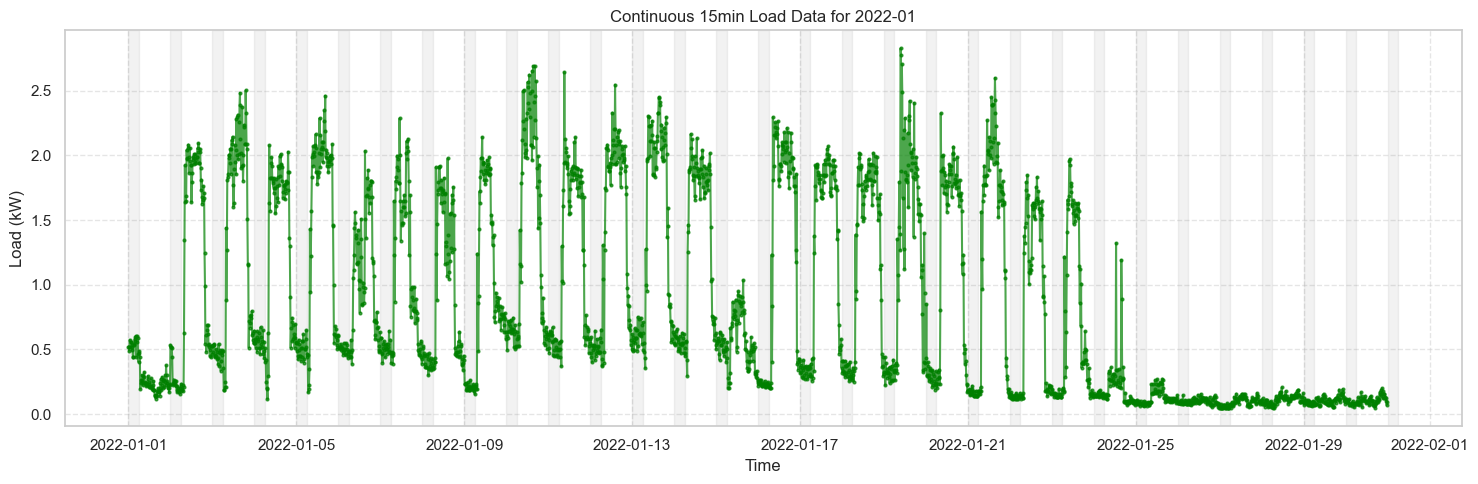

In [55]:
# Define the month to analyze (example: January 2022).
selected_month = '2022-01'
df_month = df_train.loc[selected_month].sort_index()

# Identify invalid days (days that contain at least one missing value in the power columns).
invalid_days = df_month[df_month[power_columns].isnull().any(axis=1)].index

# Remove invalid days by dropping any day with missing values.
df_clean = df_month[power_columns].dropna(how='any')

removal_missing_data = plot_monthly_load_data(df=df_clean, month_str='2022-01', power_columns=power_columns, freq='15min', color='green')

Removing 17 pre-identified invalid days
Final valid days: 687


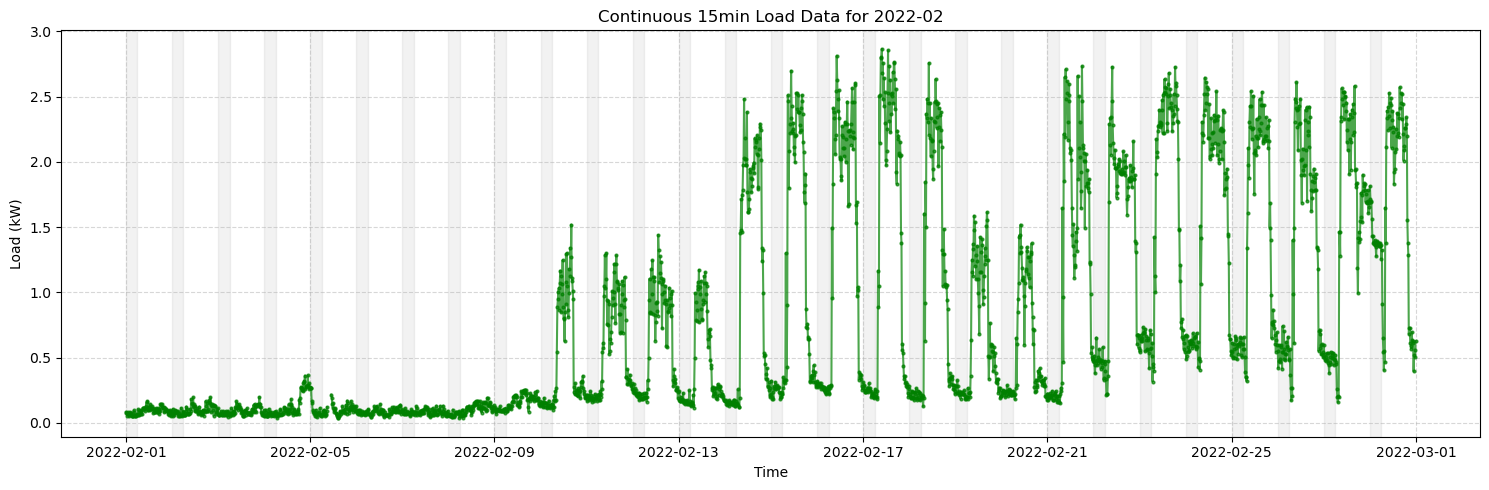

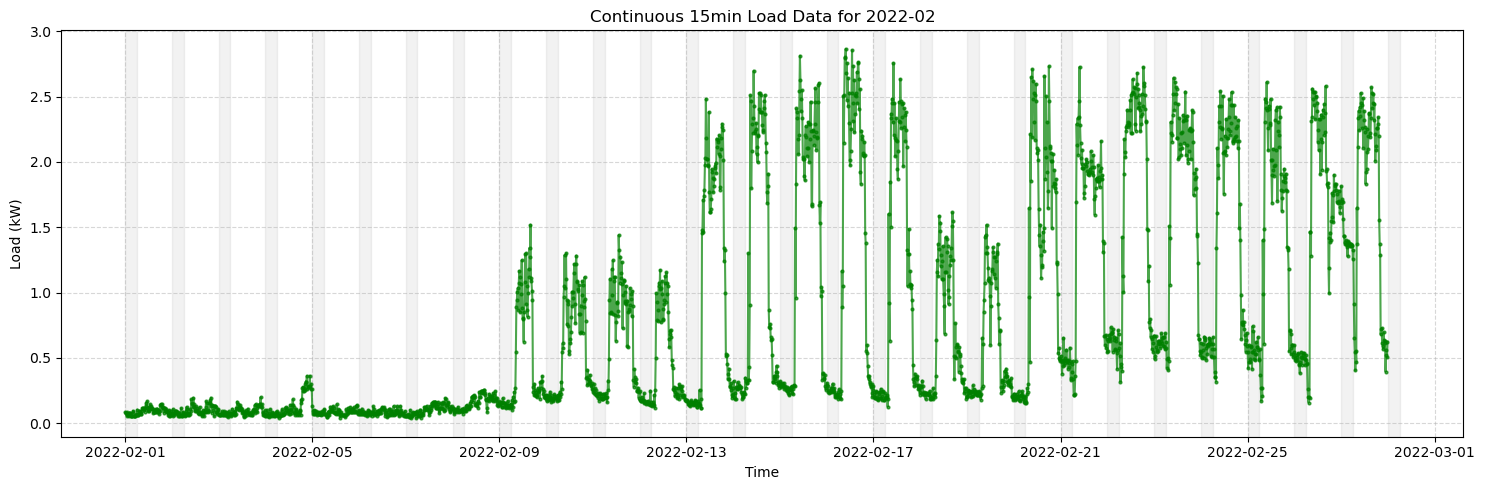

In [15]:
# Time-Series Specific Missing Data Handling
def time_series_impute(df, method='linear', invalid_days_info=None, 
                      max_consecutive_threshold=5, max_total_threshold=40,
                      power_columns=None, special_interpolation_range=27):
    df_imputed = df.copy()
    
    # Convert index to datetime if needed
    if not isinstance(df.index, pd.DatetimeIndex):
        if 'timestamp' in df.columns:
            df_imputed = df_imputed.set_index('timestamp')
        elif 'date' in df.columns:
            df_imputed = df_imputed.set_index('date')
        df_imputed.index = pd.to_datetime(df_imputed.index)
    
    # Sort by time
    df_imputed = df_imputed.sort_index()
    
    # Remove invalid days based on your detection
    if invalid_days_info:
        invalid_dates = list(invalid_days_info.keys())
        print(f"Removing {len(invalid_dates)} pre-identified invalid days")
        mask = ~df_imputed.index.normalize().isin(invalid_dates)
        df_imputed = df_imputed[mask]
    
    # Apply your special interpolation rules first
    if power_columns:
        for day, row in df_imputed.iterrows():
            arr = row[power_columns].values.copy()
            missing_bool = pd.isnull(arr)
            sequences = find_missing_sequences(missing_bool)
            
            for (start, end) in sequences:
                seq_len = end - start + 1
                
                # Apply your special rules
                if start < special_interpolation_range and end < special_interpolation_range:
                    # Linear interpolation for special range
                    left_idx = start - 1
                    right_idx = end + 1
                    left_val = arr[left_idx] if left_idx >= 0 else arr[right_idx]
                    right_val = arr[right_idx] if right_idx < len(arr) else arr[left_idx]
                    
                    for i in range(seq_len):
                        arr[start + i] = left_val + (right_val - left_val) * (i + 1) / (seq_len + 1)
                else:
                    # Handle other ranges based on sequence length
                    if seq_len == 1:
                        # Forward/backward fill
                        idx = start
                        arr[idx] = arr[idx - 1] if idx > 0 else arr[idx + 1]
                    elif 2 <= seq_len <= 4:
                        # Linear interpolation
                        left_idx = start - 1
                        right_idx = end + 1
                        left_val = arr[left_idx] if left_idx >= 0 else arr[right_idx]
                        right_val = arr[right_idx] if right_idx < len(arr) else arr[left_idx]
                        
                        for i in range(seq_len):
                            arr[start + i] = left_val + (right_val - left_val) * (i + 1) / (seq_len + 1)
            
            df_imputed.loc[day, power_columns] = arr
    
    # Apply selected imputation method to remaining missing values
    if method == 'linear':
        df_imputed = df_imputed.interpolate(method='linear')
    elif method == 'ffill':
        df_imputed = df_imputed.ffill()
    elif method == 'spline':
        df_imputed = df_imputed.interpolate(method='spline', order=3)
    elif method == 'seasonal':
        if df_imputed.index.hour.nunique() > 1:
            df_imputed = df_imputed.groupby(df_imputed.index.hour).transform(
                lambda x: x.interpolate(method='linear'))
        else:
            df_imputed = df_imputed.interpolate(method='linear')
    
    # Final processing statistics
    remaining_missing = df_imputed.isnull().sum().sum()
    if remaining_missing > 0:
        print(f"Note: {remaining_missing} missing values remain after processing")
    
    valid_days = len(df_imputed.resample('D').first().dropna())
    print(f"Final valid days: {valid_days}")
    
    return df_imputed

df_train_processed = time_series_impute(df=df_train, method='linear', invalid_days_info=invalid_days_info,
    power_columns=power_columns, special_interpolation_range=27, max_consecutive_threshold=5, max_total_threshold=40)

selected_month = '2022-02'                             # Change this string to a different month if needed.
df_month = df_train_processed.loc[selected_month]
df_month = df_month.sort_index()                       # Ensure the data for the selected month is sorted by date.

monthly = plot_monthly_load_data(df=df_train, month_str='2022-02', power_columns=power_columns, freq='15min', color='green')
imputed_missing_data = plot_monthly_load_data(df=df_month, month_str=selected_month, power_columns=power_columns, freq='15min', color='green')

In [ ]:
# Based on the observed data: we identified which dates have missing data, the count of missing data, and the specific sequence of the missing data
# This information allows us to determine how much data is missing per data entry. Hence, if the missing data is more than 40% (the tolerance we set),
# then we simply delete/remove the entry. Otherwise, we will employ the impute function to bridge the missing values.



In [ ]:
# Features Extraction
def get_season(date):                                                                    # Function to determine the season based on the month
    month = date.month
    if month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    elif month in [9, 10, 11]:
        return "Autumn"
    else:
        return "Winter"

for df in [df_train, df_validation, df_check]:                                           # Assuming 'Date' column contains datetime objects
    df['Date'] = pd.to_datetime(df['Date'])  # Ensure 'Date' is datetime
    df['TimeOfDay'] = df['Date'].dt.hour
    df['DayOfWeek'] = df['Date'].dt.dayofweek  # Monday=0, Sunday=6
    df['DayOfYear'] = df['Date'].dt.dayofyear
    # You can add more features like 'Month', 'WeekOfYear', etc.

for df in [df_train, df_validation, df_check]:
    df['Season'] = df['Date'].apply(get_season)

In [ ]:
# Model Selection and Training
"""
# Select features and target variable
features = []
target = 'NextDayLoad' # Name of the target variable (next day's total load)

# Include relevant features
features = [0] * 97
for i in range(0, 97):
    x = str(i)
    features[i]=("Power" + x)

features.append('TimeOfDay')
features.append('DayOfWeek')
features.append('Season')

# Create lagged features (previous day's load)
# ... (Code to create lagged features using df_train['Date'] and shifting)

# Combine features and target into NumPy arrays
X_train = df_train[features].values
y_train = df_train[target].values
X_val = df_validation[features].values
y_val = df_validation[target].values
X_test = df_check[features].values
y_test = df_check[target].values

# Reshape input data for LSTM (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build the LTSM Model
model = keras.Sequential()
model.add(keras.layers.LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))  # Input LSTM layer
model.add(keras.layers.LSTM(units=50))  # Hidden LSTM layer
model.add(keras.layers.Dense(1))  # Output layer

model.compile(loss='mean_squared_error', optimizer='adam')  # Compile the model

# Train the Model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))  # Adjust epochs and batch size
"""

In [ ]:
"""
# Evaluate the Model
loss = model.evaluate(X_test, y_test)  # Evaluate on the test set
print('Test Loss:', loss)

# You can also make predictions and calculate other metrics like RMSE
predictions = model.predict(X_test)
# ... (Calculate RMSE or other metrics using predictions and y_test)
"""